# Genetics Application

For this set of questions, we will explore the use of Convolutional Neural Networks to solve a problem with Biological significance (don't worry, no background knowledge is expected). Every cell in your body contains Deoxyribonucleic acid (DNA), which is essentially the instructions for making all the proteins in your body. DNA can be thought of as a very long string where the alphabet is \{A,C,T,G\}.
The physical attributes of the DNA string and its characters are not important here, except that ~98% of our DNA is physically inaccessible to external molecules. Understanding which regions of DNA are accessible and why is of great interest to scientists. This motivates learning predictive models which could accurately classify such regions. In particular, we will be implementing the deep network called [Basset](https://pubmed.ncbi.nlm.nih.gov/27197224/).


In [1]:
#@title Mount your Google Drive
%matplotlib inline
%load_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#@title Link your assignment folder & install requirements
#@markdown Enter the path to the assignment folder in your Google Drive
import sys
import os
import shutil
import warnings

folder = "/content/gdrive/MyDrive/A1" #@param {type:"string"}
!ln -Ts $folder /content/A1 2> /dev/null

# Add the assignment folder to Python path
if '/content/A1' not in sys.path:
    sys.path.insert(0, '/content/A1')

# Install requirements
!pip install -qr /content/A1/requirements.txt

# Check if CUDA is available
import torch
if not torch.cuda.is_available():
    warnings.warn('CUDA is not available.')

     |████████████████████████████████| 776.7 MB 4.2 kB/s 
     |████████████████████████████████| 2.9 MB 73.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.7.0 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.7.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.7.0 which is incompatible.


In [3]:
# unzip data
if not os.path.exists('/content/A1/1er.h5'):
    os.system('unzip /content/A1/er.zip')
    os.system('mv /content/er.h5 /content/A1/er.h5')

## Running on GPU
In Google Colab, you can run your code on GPU. This will be particularly important in CNN part of the assignment. To make sure the notebook is running on GPU, you can change the notebook settings with
* (EN) `Edit > Notebook Settings`
* (FR) `Modifier > Paramètres du notebook`

Be mindful not to use the GPU if your code does not need to run on GPU.

In [4]:
import random

import numpy as np
import h5py
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import solution

In [45]:
# The hyperparameters we will use
batch_size = 64
learning_rate = 0.01

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# set RNG
seed = 42
torch.backends.cudnn.deterministic = True
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if device.type=='cuda':
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

Let's build the dataset that we will be using. Before doing any machine learning, you should always inspect the data you will be using (especially when that data is uncommon)!

In our case, the input data are subsequences of DNA that come from the reference human genome HG19. HG19 can be thought of as the DNA of a prototypical human (but it does not come from any single person).
The input data is one-hot encoded, such that:

$$A = \begin{pmatrix} 1 \\ 0 \\ 0 \\ 0 \end{pmatrix}, C = \begin{pmatrix} 0 \\ 1 \\ 0 \\ 0 \end{pmatrix}, G = \begin{pmatrix} 0 \\ 0 \\ 1 \\ 0 \end{pmatrix}, T = \begin{pmatrix} 0 \\ 0 \\ 0 \\ 1 \end{pmatrix}$$

Each base-pair $\{A,C,G,T\}$ are concatenated along the length of the sequence. Each data point is equivalent to an image with a rectangular shape (sequence length, 4) and a single channel for data processing purposes.

The target data for our sequence are binary strings encoded as $1$ if the DNA subsequence is accessible and $0$ if it is not. This data was collected across experiments. For each sample, the target is a vector of size 164, with $1$s in the indices of the experiments where the DNA is accessible and $0$ otherwise.

# **Question 1 (Understanding the Data)** 
(10 points). You will notice that PyTorch is very object-oriented -- everything you use is the subclass of a PyTorch class. For datasets, we subclass `torch.utils.data.Dataset`.

1. Define the `__getitem__` and `__len__` methods for the `BassetDataset` class in `solution.py`
2. What is the length of each sequence we will feed into our model?  Make the `get_seq_len` method of the `BassetDataset` class to return it.
3. Is it true that each data point is also equivalent to an image with a rectangular shape (1, sequence length) with 4 channels? Write the method `is_equvalent` to return your answer (either return True or False).

Note: this data has already been pre-processed, so do not include any additional data transformations!

In [47]:
# investigate your data
f = h5py.File('/content/A1/er.h5', 'r')
f.keys()
f.close()

In [48]:
basset_dataset_train = solution.BassetDataset(path='/content/A1', f5name='er.h5', split='train')
basset_dataset_valid = solution.BassetDataset(path='/content/A1', f5name='er.h5', split='valid')
basset_dataset_test = solution.BassetDataset(path='/content/A1', f5name='er.h5', split='test')
basset_dataloader_train = DataLoader(basset_dataset_train,
                                     batch_size=batch_size,
                                     drop_last=True,
                                     shuffle=True,
                                     num_workers=1)
basset_dataloader_valid = DataLoader(basset_dataset_valid,
                                     batch_size=batch_size,
                                     drop_last=True,
                                     shuffle=False,
                                     num_workers=1)
basset_dataloader_test = DataLoader(basset_dataset_test,
                                    batch_size=batch_size,
                                    drop_last=True,
                                    shuffle=False,
                                    num_workers=1)

# **Question 2 (Building the Network)** 
(15 points). PyTorch also provides an abstraction for differentiable models: `torch.nn.Module`. In `solution.py`, we define Basset as a subclass of this class.

1. Fill in the missing values denoted as `?` within the class definition using [supplementary figure 13](https://genome.cshlp.org/content/suppl/2016/06/10/gr.200535.115.DC1/Supplementary_Figures.pdf) and convolution arithmetic.
2. Write the `forward` pass function. Again, please refer to [supplementary figure 13](https://genome.cshlp.org/content/suppl/2016/06/10/gr.200535.115.DC1/Supplementary_Figures.pdf).

  Do not include any output activation in your forward method! In practice, it is better to use a loss function that has the output activation built-in.

In [56]:
model = solution.Basset().to(device)

# **Question 3 (Area Under the Curve)** 
(25 points). Each DNA sequence is either exposed (we'll call this the positive case) or not (we'll call this the negative case). The output of our model should be used to return a binary decision about the sequence.

For a given case, we say that our model made a positive prediction whenever its output value is above some threshold $k$, and a negative prediction otherwise.

Define the *True Positive Rate* (TPR) as the number of correctly prediced positive cases divided by the number of positive cases. Define the *False Positive Rate* (FPR) as the  number of cases that were incorrectly predicted as positive divided by the number of negative cases.

1. Complete the function `compute_fpr_tpr` in `solution.py`. This code will compute the TPR and FPR given your models decisions and the true targets.

2. Your FPR and TPR change as a function of $k$. Specifically, we can plot the FPR on the x-axis and the TPR on the y-axis for different values of $k$. The shape of the resulting curve (ROC curve) tells us something about our classifiers performance. We will explore via simulation what this plot looks like when our model is just making random guesses. In `solution.py`, fill in the function `compute_fpr_tpr_dumb_model`. This function will generate 1000 binary random variables to use as targets and 1000 uniform random variables between 0 and 1 as our model predictions. It will then compute the fpr and tpr for $k\in \{0, 0.05,..., 0.95\}$ You should plot what the ROC curves look like for your own knowledge.

In [ ]:
dumb_output = solution.compute_fpr_tpr_dumb_model()

3. We will now simulate a better model. In `solution.py`, fill in the function `compute_fpr_tpr_smart_model`. This will simulate 1000 targets the same way as before. However, this will simulate model outputs as uniform random variables between 0.4 and 1 for the positive cases. For the negative cases, simulate uniform random variables between 0 and 0.6. Compute the tpr and fpr varying $k$ like before. You should also look at the ROC curve.

In [ ]:
smart_output = solution.compute_fpr_tpr_smart_model()

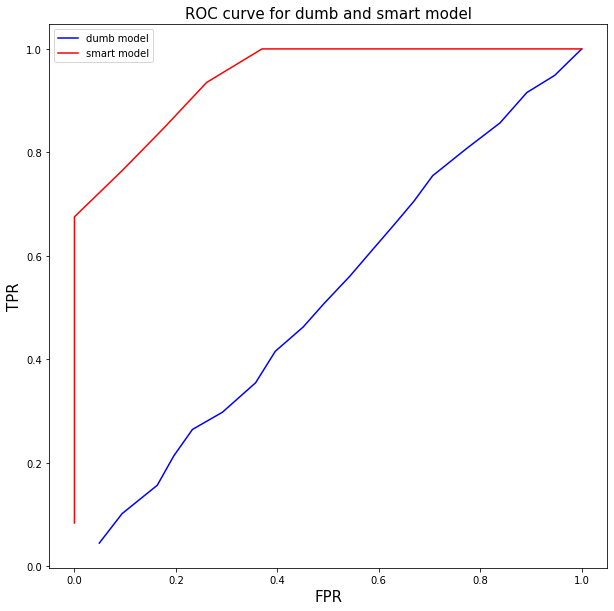

In [ ]:
import matplotlib.pyplot as plt

# Plotting the ROC curves
f,ax = plt.subplots(figsize = (10,10))
plt.plot(dumb_output['fpr_list'], dumb_output['tpr_list'], label='dumb model', color="blue")
plt.plot(smart_output['fpr_list'], smart_output['tpr_list'], label='smart model', color="red")
plt.xlabel("FPR", fontsize = 15)
plt.ylabel("TPR", fontsize = 15)
plt.title("ROC curve for dumb and smart model", fontsize = 15)
plt.legend()
plt.show()

4. The Area Under the ROC Curve (AUC) summarizes the ROC plot as a single number. It is literally computed as the area under the the ROC curve (take the average of the left and right Reimann sums). Complete the function `utils.compute_auc`. Then, in `compute_auc_both_models`, recreate the dumb and smart models from parts 2 and 3 and compute the AUC of them.

In [ ]:
solution.compute_auc_both_models()

{'auc_dumb_model': 0.46418066344110553, 'auc_smart_model': 0.948607125848911}

5. Complete the function `compute_auc_untrained_model`, which will compute the AUC of your untrained model.

    Note: since we are doing multi-task prediction, your model outputs and targets will have shape (Batch size, Num targets). Flatten these matrices so that they are two vectors, each of size Batch size * Num targets.
    Then, procede with AUC as if you were in the usual single task case...

In [ ]:
solution.compute_auc_untrained_model(model, basset_dataloader_test, device)

{'auc': 0.5046602551293573}

# **Question 4 (Training the Network)**
(20 points) We will now write the training loop for Basset.

1. Notice that for each input, we have one target per experiment, and each target is binary. Write the function `get_critereon`, which will pick the appropriate `loss` function. 

  Hint: you may consult the [relevant PyTorch documentation](https://pytorch.org/docs/stable/nn.html#loss-functions)



In [57]:
criterion = solution.get_critereon()

2. Finish the training loop by filling in the missing code for the `train_loop`  pass and `valid_loop` functions in `solution.py.`

    Both loops must return the loss and AUC (computed the same way as the previous question). They must be returned by each function (see the docstring for more details).

In [58]:
optimizer = optim.Adam(list(model.parameters()), lr=learning_rate, betas=(0.9, 0.999))

valid_score_best = 0
patience = 2
num_epochs = 5  # you don't need to train this for that long!

for e in range(num_epochs):
    train_score, train_loss = solution.train_loop(model, basset_dataloader_train, device, optimizer, criterion)
    valid_score, valid_loss = solution.valid_loop(model, basset_dataloader_valid, device, optimizer, criterion)

    print('epoch {}: loss={:.3f} score={:.3f}'.format(e,
                                                      valid_loss,
                                                      valid_score))

    if valid_score > valid_score_best:
        print('Best score: {}. Saving model...'.format(valid_score))
        torch.save(model, 'model_params.pt')
        valid_score_best = valid_score
    else:
        patience -= 1
        print('Score did not improve! {} <= {}. Patience left: {}'.format(valid_score,
                                                                          valid_score_best,
                                                                          patience))
    if patience == 0:
        print('patience reduced to 0. Training Finished.')
        break

For 50 batches, score=0.542
For 100 batches, score=0.605
For 150 batches, score=0.674
For 200 batches, score=0.716
For 250 batches, score=0.699
For 300 batches, score=0.692
For 350 batches, score=0.693
For 400 batches, score=0.705
For 450 batches, score=0.710
For 500 batches, score=0.712
For 550 batches, score=0.706
For 600 batches, score=0.710
For 650 batches, score=0.698
For 700 batches, score=0.700
For 750 batches, score=0.708
For 800 batches, score=0.707
For 850 batches, score=0.709
For 900 batches, score=0.712
For 950 batches, score=0.707
For 1000 batches, score=0.707
For 1050 batches, score=0.707
For 1100 batches, score=0.709
For 1150 batches, score=0.711
For 1200 batches, score=0.707
For 1250 batches, score=0.708
For 1300 batches, score=0.705
For 1350 batches, score=0.703
For 1400 batches, score=0.706
For 1450 batches, score=0.706
For 1500 batches, score=0.704
For 1550 batches, score=0.705
For 1600 batches, score=0.705
For 1650 batches, score=0.702
For 1700 batches, score=0.704


In [59]:
# epoch 4: loss=0.001 score=0.832
# Score did not improve! 0.8323864259263286 <= 0.8426421859572849. Patience left: 1

# **Question 5 (Interpreting the Model)**

(30 points) In real-world applications of deep learning, it is *crucial* that we verify that our models are learning what we expect them to learn. In this exercise, we will replicate a part of figure 3b from [Basset](https://pubmed.ncbi.nlm.nih.gov/27197224/).

In genetics, there exists well known DNA *motifs*: short sequences which appear throughtout our DNA, and whose function are well documented. We expect that the filters of the first convolution layer should learn to identify some of these motifs in order to solve this task.

**Please submit the answers to this exercise on a single paged PDF!**

1. First, we need to ensure that our model has learned something. Plot the ROC curve and compute the AUC of your model after training. Compare the ROC curves and the AUC before and after training with your simulated models. What do you notice?

In [61]:
untrained_model = solution.Basset().to(device)
trained_model = torch.load("/content/gdrive/MyDrive/A1/model_params.pt")

In [62]:
untrained_model = untrained_model.to(device)
untrained_model.eval()
auc_test = []
y_model_untrained = torch.Tensor()
y_true_untrained = torch.Tensor()

with torch.set_grad_enabled(False) :
  for i, dictionary in enumerate(basset_dataloader_test):
    # Transfer to GPU
    sequence, target = dictionary["sequence"].to(device), dictionary["target"].to(device)
    # Model computations
    outputs = untrained_model(sequence)
    y_model = torch.sigmoid(outputs)
    # # Concatenate y_true
    y_true = target.cpu()
    y_true_untrained = torch.cat((y_true_untrained, y_true))
    # # Concatenate y_model
    y_model = y_model.detach().cpu()
    y_model_untrained = torch.cat((y_model_untrained, y_model))

# From tensor to numpy
y_model_untrained = y_model_untrained.float().numpy().flatten()
y_true_untrained = y_true_untrained.int().numpy().flatten()

In [63]:
untrained_auc, untrained_fpr, untrained_tpr = solution.compute_auc(y_true_untrained, y_model_untrained)

In [ ]:
# 'auc': 0.49752832994235585
untrained_auc

{'auc': 0.49752832994235585}

In [ ]:
trained_model = trained_model.to(device)
trained_model.eval()

y_model_trained = torch.Tensor()
y_true_trained = torch.Tensor()

with torch.set_grad_enabled(False) :
  for i, dictionary in enumerate(basset_dataloader_test) :
    # Transfer to GPU
    sequence, target = dictionary["sequence"].to(device), dictionary["target"].to(device)
    # Model computations
    outputs = trained_model(sequence)
    y_model = torch.sigmoid(outputs)
    # Concatenate y_true
    y_true = target.cpu()
    y_true_trained = torch.cat((y_true_trained, y_true))
    # Concatenate y_model
    y_model = y_model.detach().cpu()
    y_model_trained = torch.cat((y_model_trained, y_model))

# From tensor to numpy
y_model_trained = y_model_trained.float().numpy().flatten()
y_true_trained = y_true_trained.int().numpy().flatten()


In [ ]:
trained_auc, trained_fpr, trained_tpr = solution.compute_auc(y_true_trained, y_model_trained)

In [ ]:
# 'auc': 0.8429816675640787
trained_auc

{'auc': 0.8429816675640787}

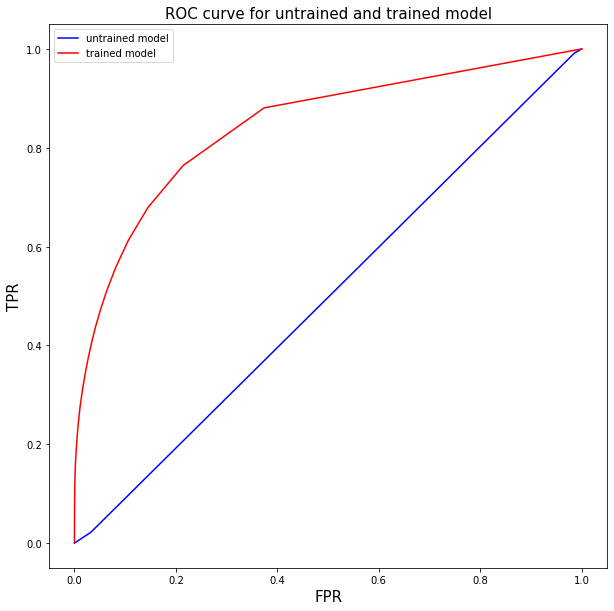

In [ ]:
import matplotlib.pyplot as plt

# Plotting the ROC curves
f,ax = plt.subplots(figsize = (10,10))
plt.plot(untrained_fpr, untrained_tpr, label='untrained model', color="blue")
plt.plot(trained_fpr, trained_tpr, label='trained model', color="red")
plt.xlabel("FPR", fontsize = 15)
plt.ylabel("TPR", fontsize = 15)
plt.title("ROC curve for untrained and trained model", fontsize = 15)
plt.legend()
plt.show()

2. We represent motifs as position weight matrices (PWMs). This is a matrix of size $4$ $\times$ the motif length, where the $(i,j)$th entry is a count of how often base-pair $i$ occurs at position $j$. Open the PWM for the CTCF motif, which can be found in `MA0139.1.jaspar`. Normalize this matrix so that each column sums to $1$. Display the PWM.

In [10]:
import pandas as pd
PWM = pd.read_csv('/content/gdrive/MyDrive/A1/matrice.txt', header=None, index_col=0)
PWM

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,,,,,,,,,,,,,,,,,,,
A,87,167,281,56,8,744,40,107,851,5,333,54,12,56,104,372,82,117,402
C,291,145,49,800,903,13,528,433,11,0,3,12,0,8,733,13,482,322,181
G,76,414,449,21,0,65,334,48,32,903,566,504,890,775,5,507,307,73,266
T,459,187,134,36,2,91,11,324,18,3,9,341,8,71,67,17,37,396,59


In [11]:
PWM_np = PWM.to_numpy()
PWM_np = PWM_np/PWM_np.sum(axis=0,keepdims=1)
PWM_norm = pd.DataFrame(PWM_np, index = ["A", "C", "G", "T"])
PWM_norm

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
A,0.095290,0.182913,0.307777,0.061336,0.008762,0.814896,0.043812,0.117325,0.933114,0.005488,0.365532,0.059276,0.013187,0.061538,0.114411,0.409241,0.090308,0.128855,0.442731
C,0.318729,0.158817,0.053669,0.876232,0.989047,0.014239,0.578313,0.474781,0.012061,0.000000,0.003293,0.013172,0.000000,0.008791,0.806381,0.014301,0.530837,0.354626,0.199339
G,0.083242,0.453450,0.491785,0.023001,0.000000,0.071194,0.365827,0.052632,0.035088,0.991218,0.621295,0.553238,0.978022,0.851648,0.005501,0.557756,0.338106,0.080396,0.292952
T,0.502738,0.204819,0.146769,0.039430,0.002191,0.099671,0.012048,0.355263,0.019737,0.003293,0.009879,0.374314,0.008791,0.078022,0.073707,0.018702,0.040749,0.436123,0.064978


3. In the methods section of the [paper](https://pubmed.ncbi.nlm.nih.gov/27197224/) (page 998), the authors describe how they converted each of the $300$ filters into normalized PWMs. First, for each filter, they determined the maximum activated value across the *dataset* (you may use a subset of the test set here). Compute these values.

In [64]:
max_values = torch.zeros(300)
max_values = max_values.to(device)

for i, data in enumerate(basset_dataloader_test):
    with torch.no_grad():
        # Transfer to GPU
        sequence = data['sequence'].to(device)
        w = torch.Tensor([])
        # Model computations
        activ = trained_model.conv1(sequence)
        w = torch.max(torch.max(activ,2).values,0).values.squeeze()
        w = w.to(device)
        max_values = torch.max(max_values, w)


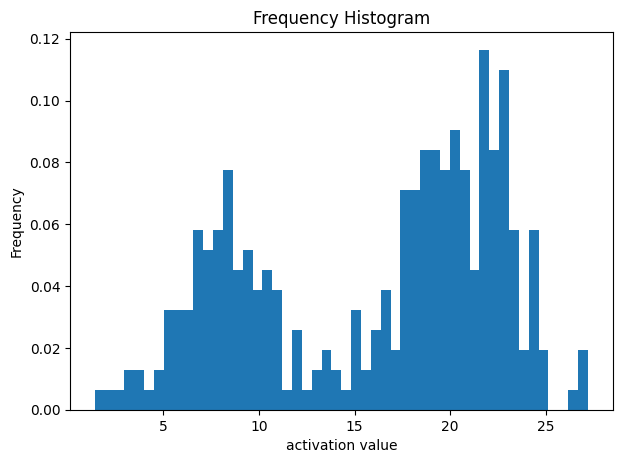

In [103]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

max_values = max_values.cpu()
# Plot Histogram on max_values
plt.hist(max_values.cpu(), bins=50, density=True)
plt.gca().set(title='Frequency Histogram', xlabel='activation value', ylabel='Frequency');

In [66]:
torch.median(max_values)

tensor(18.2924)

In [104]:
max_values

tensor([18.0620, 21.8191, 10.9657,  5.4022,  8.7240,  7.7070,  7.5565, 21.8017,
        19.2293, 17.4454, 16.8911,  9.0526,  2.6300, 24.7143,  6.4048, 18.7462,
        21.3259, 19.4477,  8.3740, 23.3308, 14.9217,  5.5815, 21.7513, 24.4339,
         7.8069, 22.9326, 15.2146,  9.3924, 11.2012, 21.9014, 15.2153, 11.8606,
         9.2935, 12.9346, 22.4881, 21.8707, 20.7941, 22.7814,  7.5684, 22.7144,
        16.0883,  5.8810, 22.6403,  7.7498, 17.7706, 20.3221, 22.3368, 16.5826,
        23.1423, 19.4614, 20.1505, 18.9701, 22.7369, 22.3619,  7.4534, 18.5953,
         8.1662,  6.0777,  6.8557, 17.8359,  8.2695, 20.0820, 20.3602, 16.2629,
        23.2811, 16.9977, 20.4952, 19.3251, 19.5301, 17.2661, 16.2683, 21.1528,
        18.3072,  7.8002, 24.4297,  4.3140, 20.9875,  7.0081,  7.3629, 20.8258,
        21.7367, 19.7477, 16.8246, 23.8271, 23.1726, 18.3643,  8.1732, 19.7036,
         7.2525, 15.7242,  9.9677, 21.1584, 24.4158, 19.6702,  3.7194, 18.8762,
        10.9677, 18.2265,  7.6051, 27.19


4. Next, they counted the base-pair occurrences in the set of sequences that activate the filter to a value that is more than half of its maximum value.

  Note: You should use `torch.functional.unfold`.

In [67]:
results = np.zeros((4,300))
empty = np.zeros((300,4))
count = np.zeros((300,19,4))

unfold = torch.nn.Unfold(kernel_size=(19,4), padding=(9,0), stride=(1,1))

dataloader_iterator=iter(basset_dataloader_test)
dataloader = basset_dataloader_test
num_batches = len(basset_dataloader_test)
n = trained_model.conv1.weight.detach().cpu().numpy()
for batch in range(num_batches):
    print('Batch', batch, 'starts')
    data = next(dataloader_iterator)
    x = data["sequence"]
    y = data["target"]

    print(unfold(x).shape) 
    unfolded_x = unfold(x).reshape((64, 19, 4, 600)).permute((0,3,1,2))

    output = np.zeros((64, 600, 300, 1))
    for i, item in enumerate(unfolded_x): 
    print("\tItem", i, "starts")
    for i_k, input_kernel in enumerate(item):
        input_kernel = input_kernel.numpy()
        for k, kernel in enumerate(n):
            kernel = kernel.reshape(19, 4)
            conv_result = np.sum(input_kernel * kernel)

        output[i, i_k, k] = conv_result
        if conv_result > max_values[k]/2:
            count[k] = count[k] + input_kernel
    if(batch == 0):
    break;

Batch 0 starts
torch.Size([64, 76, 600])
	Item 0 starts
	Item 1 starts
	Item 2 starts
	Item 3 starts
	Item 4 starts
	Item 5 starts
	Item 6 starts
	Item 7 starts
	Item 8 starts
	Item 9 starts
	Item 10 starts
	Item 11 starts
	Item 12 starts
	Item 13 starts
	Item 14 starts
	Item 15 starts
	Item 16 starts
	Item 17 starts
	Item 18 starts
	Item 19 starts
	Item 20 starts
	Item 21 starts
	Item 22 starts
	Item 23 starts
	Item 24 starts
	Item 25 starts
	Item 26 starts
	Item 27 starts
	Item 28 starts
	Item 29 starts
	Item 30 starts
	Item 31 starts
	Item 32 starts
	Item 33 starts
	Item 34 starts
	Item 35 starts
	Item 36 starts
	Item 37 starts
	Item 38 starts
	Item 39 starts
	Item 40 starts
	Item 41 starts
	Item 42 starts
	Item 43 starts
	Item 44 starts
	Item 45 starts
	Item 46 starts
	Item 47 starts
	Item 48 starts
	Item 49 starts
	Item 50 starts
	Item 51 starts
	Item 52 starts
	Item 53 starts
	Item 54 starts
	Item 55 starts
	Item 56 starts
	Item 57 starts
	Item 58 starts
	Item 59 starts
	Item 60 

In [68]:
torch.save(count, 'count_2.pt')

In [115]:
count = torch.load('/content/gdrive/MyDrive/A1/count_2.pt')

In [116]:
count_new = np.transpose(count, (0, 2, 1))

5. Given your 300 PWMs derived from your convolution filters, check to see if any of them are similar to the PWM for CTCF. You could quantify the similarity using *Pearson Correlation Coefficient*. Make a visualization of the PWM of the CTCF motif along with the most similar ones learned from the network. 

In [106]:
from scipy.stats import pearsonr
corr = []
dic = {'PWM': 0., 'values': 0.}
for i in range(300) :
  X = count_new[i]/count_new[i].sum(axis=0,keepdims=1)
  X = np.nan_to_num(X)
  PWM_np = np.nan_to_num(PWM_np)
  correlation, p_value = pearsonr(PWM_np.flatten(), X.flatten())
  corr.append(correlation)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [107]:
corr_ = np.nan_to_num(corr)

In [108]:
max(corr_)

0.6699517986180339

In [121]:
indx = np.where(corr_ > 0.55)

In [122]:
indx

(array([119, 145, 232]),)

In [125]:
corr_[232]

0.5747609141030597

In [142]:
from scipy.stats import pearsonr
corr = []
indx = [119, 145, 232]
names = ["PWM_1", "PWM_2", "PWM_3"]
PWM_np = np.nan_to_num(PWM_np).flatten()

dic = {"CTCF" : PWM_np}
t = 0
for i in range(300) :
  X = count_new[i]/count_new[i].sum(axis=0,keepdims=1)
  X = np.nan_to_num(X).flatten()
  correlation, p_value = pearsonr(PWM_np, X)
  correlation = np.nan_to_num(correlation)
  corr.append(correlation)
  if i in indx :
    dic[names[t]] = X
    t += 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [143]:
dic

{'CTCF': array([0.09529025, 0.18291347, 0.30777656, 0.06133625, 0.00876232,
        0.81489595, 0.04381161, 0.11732456, 0.93311404, 0.00548847,
        0.36553238, 0.05927552, 0.01318681, 0.06153846, 0.11441144,
        0.40924092, 0.09030837, 0.12885463, 0.44273128, 0.31872946,
        0.15881709, 0.05366922, 0.8762322 , 0.9890471 , 0.01423877,
        0.57831325, 0.4747807 , 0.0120614 , 0.        , 0.00329308,
        0.01317234, 0.        , 0.00879121, 0.80638064, 0.01430143,
        0.530837  , 0.35462555, 0.19933921, 0.08324206, 0.45345016,
        0.49178532, 0.0230011 , 0.        , 0.07119387, 0.36582694,
        0.05263158, 0.03508772, 0.99121844, 0.62129528, 0.5532382 ,
        0.97802198, 0.85164835, 0.00550055, 0.55775578, 0.33810573,
        0.08039648, 0.29295154, 0.50273823, 0.20481928, 0.14676889,
        0.03943045, 0.00219058, 0.09967141, 0.01204819, 0.35526316,
        0.01973684, 0.00329308, 0.00987925, 0.37431394, 0.00879121,
        0.07802198, 0.07370737, 0.018701

In [144]:
df = pd.DataFrame(dic)

In [145]:
df

,CTCF,PWM_1,PWM_2,PWM_3
0,0.095290,0.00,0.2,0.666667
1,0.182913,0.00,0.4,0.666667
2,0.307777,0.50,0.4,0.333333
3,0.061336,0.00,0.2,0.000000
4,0.008762,0.00,0.0,0.000000
...,...,...,...,...
71,0.073707,0.00,0.4,0.666667
72,0.018702,0.00,0.2,0.000000
73,0.040749,0.25,0.6,0.000000
74,0.436123,0.25,0.0,0.333333


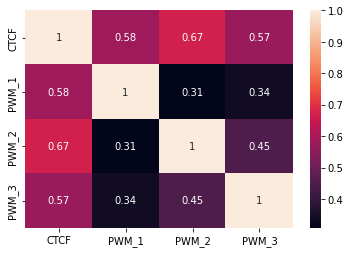

In [146]:
import seaborn as sns
%matplotlib inline

sns.heatmap(df.corr(), annot=True)

**A couple of points that may help you with this question**
* I've noticed that instances of Google Colab vary significantly in speed (probably the GPU you are assigned). If your code is running very slowly, you can restart it until you get a faster instance.
* You are free to change the scoring function when training (I use the same AUC but changed the increments of thresholds from 0.05 to 0.01 and found that the score increased more visibly).